<a href="https://colab.research.google.com/github/saumilhj/dsai_projects/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMAGE CLASSIFICATION WITH CUSTOM CONVNET AND WITH INCEPTIONV3**

Dataset from Kaggle: https://www.kaggle.com/datasets/alessiocorrado99/animals10

### Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import shutil
import matplotlib.pyplot as plt

### Data Preprocessing

Unzip the file to get all images

In [ ]:
!unzip drive/MyDrive/Data/raw-img.zip

Set seed

In [3]:
SEED = 12
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Set path to root folder

In [4]:
ROOT_PATH = "./raw-img"

In [5]:
# This dictionary gives the translated names of animals in the dataset
translated = {"cane": "dog", "cavallo": "horse", "elefante": "elephant",
              "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
              "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel",
              "ragno": "spider"}

Function defined to create the right directories and split data into training and validation

In [6]:
def data_split(root_path, split_size):
  # Get list of all directories in the main folder
  folders = os.listdir(root_path)
  for folder in folders:
    # Create train and validation directory for each category
    os.makedirs(f"./train/{translated[folder]}")
    os.makedirs(f"./validation/{translated[folder]}")
    # Save the newly created directory path in variables
    training_dir = f"./train/{translated[folder]}"
    validation_dir = f"./validation/{translated[folder]}"
    # Split images into training and validation
    images = os.listdir(os.path.join(root_path, folder))
    train_images = random.sample(images, int(split_size*len(images)))
    validation_images = list(set(images) - set(train_images))
    # Copy images from the root folder to the new training and validation folder
    for img in train_images:
      shutil.copyfile(os.path.join(os.path.join(root_path, folder), img), os.path.join(training_dir, img))
    for img in validation_images:
      shutil.copyfile(os.path.join(os.path.join(root_path, folder), img), os.path.join(validation_dir, img))

In [7]:
data_split(root_path=ROOT_PATH, split_size=0.9)

Count number of images in training and validation directories

In [8]:
animals_train = os.listdir("./train")
print("Training Images ...")
for animal in animals_train:
  print(f"{animal} images: {len(os.listdir(os.path.join('./train', animal)))}")
animals_validation = os.listdir("./validation")
print("\nValidation Images ...")
for animal in animals_validation:
  print(f"{animal} images: {len(os.listdir(os.path.join('./validation', animal)))}")

Training Images ...
spider images: 4338
sheep images: 1638
dog images: 4376
elephant images: 1301
cow images: 1679
cat images: 1501
butterfly images: 1900
horse images: 2360
chicken images: 2788
squirrel images: 1675

Validation Images ...
spider images: 483
sheep images: 182
dog images: 487
elephant images: 145
cow images: 187
cat images: 167
butterfly images: 212
horse images: 263
chicken images: 310
squirrel images: 187


Image generators for training and validation directories

In [9]:
TRAINING_DIR = "./train"
VALIDATION_DIR = "./validation"
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical'
)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical'
)

Found 23556 images belonging to 10 classes.
Found 2623 images belonging to 10 classes.


### Model

Custom callback that will stop training if accuracy reaches over 85%

In [16]:
class CustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') is not None and logs.get('accuracy')>0.85:
      print("\nAccuracy above 85% reached. Training Stopped.")
      self.model.stop_training=True

Define custom model

In [17]:
def custom_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,3)),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])
  return model

In [18]:
custom_model = custom_model()
acc_callback = CustomCallback()
custom_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
custom_history = custom_model.fit(train_generator, validation_data=validation_generator, epochs=20, verbose=1, callbacks=[acc_callback])

Epoch 1/20
185/185 [==============================] - 200s 1s/step - loss: 1.9515 - accuracy: 0.3162 - val_loss: 1.7133 - val_accuracy: 0.4106
Epoch 2/20
185/185 [==============================] - 197s 1s/step - loss: 1.5751 - accuracy: 0.4588 - val_loss: 1.8738 - val_accuracy: 0.3797
Epoch 3/20
185/185 [==============================] - 198s 1s/step - loss: 1.4469 - accuracy: 0.5065 - val_loss: 1.3912 - val_accuracy: 0.5322
Epoch 4/20
185/185 [==============================] - 195s 1s/step - loss: 1.3564 - accuracy: 0.5386 - val_loss: 1.4890 - val_accuracy: 0.5151
Epoch 5/20
185/185 [==============================] - 196s 1s/step - loss: 1.3007 - accuracy: 0.5584 - val_loss: 1.2822 - val_accuracy: 0.5631
Epoch 6/20
185/185 [==============================] - 193s 1s/step - loss: 1.2367 - accuracy: 0.5805 - val_loss: 1.3528 - val_accuracy: 0.5383
Epoch 7/20
185/185 [==============================] - 194s 1s/step - loss: 1.2040 - accuracy: 0.5947 - val_loss: 1.3967 - val_accuracy: 0.5204

Performance

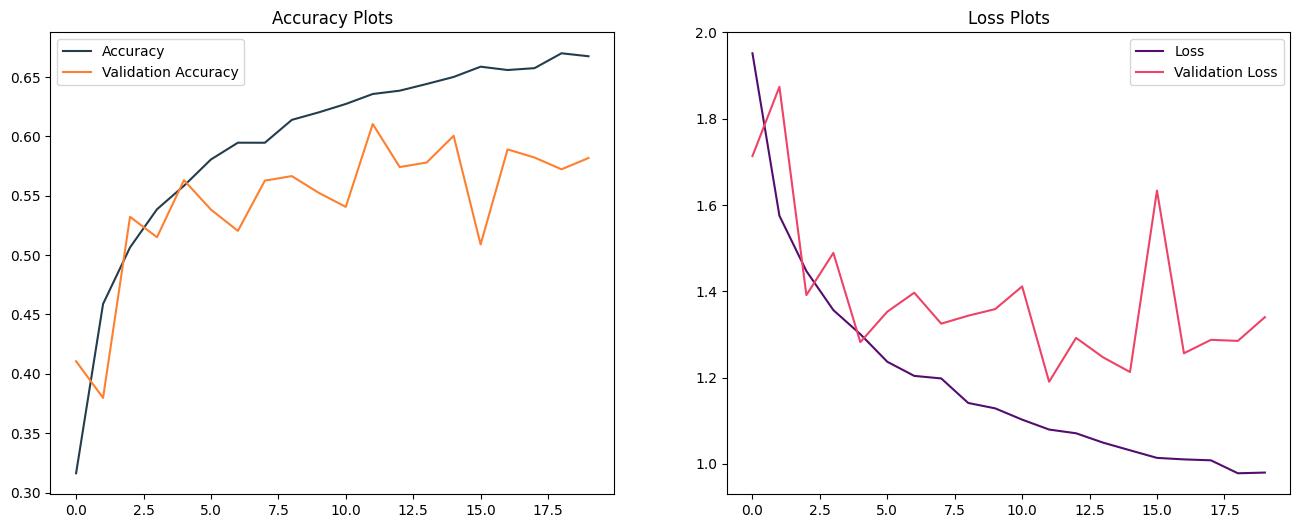

In [26]:
# Get values of metrics
accuracy = custom_history.history['accuracy']
val_accuracy = custom_history.history['val_accuracy']
loss = custom_history.history['loss']
val_loss = custom_history.history['val_loss']

epochs = range(len(accuracy))

# Plot accuracy
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(epochs, accuracy, color="#233D4D", label="Accuracy")
plt.plot(epochs, val_accuracy, color="#FE7F2D", label="Validation Accuracy")
plt.title("Accuracy Plots")
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, color="#540D6E", label="Loss")
plt.plot(epochs, val_loss, color="#EE4266", label="Validation Loss")
plt.title("Loss Plots")
plt.legend()
plt.show()

After running for all 20 epochs, the training accuracy reaches about 65% and validation accuracy reaches about 60%

Initialize InceptionV3

In [ ]:
pretrained = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    input_shape=(150,150,3),
    weights='imagenet'
)
# No training for the layers
for layer in pretrained.layers:
  layer.trainable=False
# All layers of model
pretrained.summary()

For this example, instead of taking the whole model, I am taking layers only upto mixed7

In [30]:
def transfer_model():
  last_layer=pretrained.get_layer('mixed7')
  last_output = last_layer.output
  # Custom layers joined to pretrained model
  x = tf.keras.layers.Flatten()(last_output)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dense(10, activation='softmax')(x)

  model = tf.keras.Model(inputs=pretrained.inputs, outputs=x)
  return model

In [31]:
transfer_model = transfer_model()
acc_callback = CustomCallback()
transfer_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
transfer_history = transfer_model.fit(train_generator, validation_data=validation_generator, epochs=20, verbose=1, callbacks=[acc_callback])

Epoch 1/20
185/185 [==============================] - 217s 1s/step - loss: 0.5159 - accuracy: 0.8375 - val_loss: 0.2589 - val_accuracy: 0.9157
Epoch 2/20
185/185 [==============================] - ETA: 0s - loss: 0.2986 - accuracy: 0.9021
Accuracy above 85% reached. Training Stopped.
185/185 [==============================] - 194s 1s/step - loss: 0.2986 - accuracy: 0.9021 - val_loss: 0.2431 - val_accuracy: 0.9215


Within 2 epochs itself, the training accuracy reaches 90% and the validation accuracy reaches 92%